# Stock Price Prediction with LSTM

In this project, I perform time series prediction using a Recurrent Neural network(RNN) regressor. For this example, I will predict PNC's stock price 7 days in advance.

The particular network architecture I will employ for my RNN is Long Term Short Memory (LSTM), which helps significantly avoid technical problems with optimization of RNNs.

Pytorch LSTM Stock Predictor - This is a Pytorch version of the original Keras Stock Predictor provided by Super DataScience, and also available elsewhere in this repo as a notebook.

## Step 1: Loading the data

First load in the time series - a history of around 140 days of Apple's stock price. Then we need to perform a number of pre-processing steps to prepare it for use with an RNN model.  First off, it is good practice to normalize time series - by normalizing its range.  This helps us avoid serious numerical issues associated how common activation functions (like tanh) transform very large (positive or negative) numbers, as well as helping us to avoid related issues when computing derivatives.

Here we normalize the series to lie in the range [0,1] [using this scikit function](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).

In [1]:
# download the data
!wget https://raw.githubusercontent.com/tonylaioffer/stock-prediction-lstm-using-keras/master/data/sandp500/all_stocks_5yr.csv

--2022-03-14 13:45:28--  https://raw.githubusercontent.com/tonylaioffer/stock-prediction-lstm-using-keras/master/data/sandp500/all_stocks_5yr.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29580549 (28M) [text/plain]
Saving to: ‘all_stocks_5yr.csv’

all_stocks_5yr.csv  100%[===================>]  28.21M   106MB/s    in 0.3s    

2022-03-14 13:45:29 (106 MB/s) - ‘all_stocks_5yr.csv’ saved [29580549/29580549]



In [2]:
!ls

all_stocks_5yr.csv  sample_data


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn as nn
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [4]:
# Importing the training set
df_all_stocks = pd.read_csv('./all_stocks_5yr.csv')
data_pnc = df_all_stocks[df_all_stocks["Name"] == "PNC"].close.values

In [5]:
df_all_stocks.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [6]:
data_pnc[0:10]

array([63.35, 64.  , 64.77, 64.17, 63.87, 63.87, 63.51, 63.17, 62.39,
       62.9 ])

In [7]:
df_all_stocks.Name.unique()

array(['AAL', 'AAPL', 'AAP', 'ABBV', 'ABC', 'ABT', 'ACN', 'ADBE', 'ADI',
       'ADM', 'ADP', 'ADSK', 'ADS', 'AEE', 'AEP', 'AES', 'AET', 'AFL',
       'AGN', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALK',
       'ALLE', 'ALL', 'ALXN', 'AMAT', 'AMD', 'AME', 'AMGN', 'AMG', 'AMP',
       'AMT', 'AMZN', 'ANDV', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'APC',
       'APD', 'APH', 'APTV', 'ARE', 'ARNC', 'ATVI', 'AVB', 'AVGO', 'AVY',
       'AWK', 'AXP', 'AYI', 'AZO', 'A', 'BAC', 'BAX', 'BA', 'BBT', 'BBY',
       'BDX', 'BEN', 'BF.B', 'BHF', 'BHGE', 'BIIB', 'BK', 'BLK', 'BLL',
       'BMY', 'BRK.B', 'BSX', 'BWA', 'BXP', 'CAG', 'CAH', 'CAT', 'CA',
       'CBG', 'CBOE', 'CBS', 'CB', 'CCI', 'CCL', 'CDNS', 'CELG', 'CERN',
       'CFG', 'CF', 'CHD', 'CHK', 'CHRW', 'CHTR', 'CINF', 'CI', 'CLX',
       'CL', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP',
       'COF', 'COG', 'COL', 'COO', 'COP', 'COST', 'COTY', 'CPB', 'CRM',
       'CSCO', 'CSRA', 'CSX', 'CTAS', 'CTL', 'CTSH', 'CTXS

In [8]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

# scale the data
data_pnc = data_pnc.reshape(data_pnc.shape[0], 1)
data_pnc = scaler.fit_transform(data_pnc)

In [9]:
data_pnc[0:10]

array([[0.025714  ],
       [0.03232036],
       [0.04014636],
       [0.03404818],
       [0.03099909],
       [0.03099909],
       [0.02734018],
       [0.02388454],
       [0.01595691],
       [0.02114036]])

## Step 2:  Cutting our time series into sequences

Remember, our time series is a sequence of numbers that we can represent in general mathematically as 

$$s_{0},s_{1},s_{2},...,s_{P}$$

where $s_{p}$ is the numerical value of the time series at time period $p$ and where $P$ is the total length of the series.  In order to apply our RNN we treat the time series prediction problem as a regression problem, and so need to use a sliding window to construct a set of associated input/output pairs to regress on.  This process is animated in the gif below.

<img src="https://github.com/tonylaioffer/stock-prediction-lstm-using-keras/raw/master/images/timeseries_windowing_training.gif" width=600 height=288/>

For example - using a window of size T = 5 (as illustrated in the gif above) we produce a set of input/output pairs like the one shown in the table below

$$\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline \color{CornflowerBlue} {\langle s_{1},s_{2},s_{3},s_{4},s_{5}\rangle} & \color{Goldenrod}{ s_{6}} \\
\ \color{CornflowerBlue} {\langle s_{2},s_{3},s_{4},s_{5},s_{6} \rangle } & \color{Goldenrod} {s_{7} } \\
\color{CornflowerBlue}  {\vdots} & \color{Goldenrod} {\vdots}\\
\color{CornflowerBlue} { \langle s_{P-5},s_{P-4},s_{P-3},s_{P-2},s_{P-1} \rangle } & \color{Goldenrod} {s_{P}}
\end{array}$$

Notice here that each input is a sequence (or vector) of length 4 (and in general has length equal to the window size T) while each corresponding output is a scalar value.  Notice also how given a time series of length P and window size T = 5 as shown above, we created P - 5  input/output pairs.  More generally, for a window size T we create P - T such pairs.

Now let's window the input time series as described above!  

In [10]:
#Create a function to process the data into 7 day look back slices
def processData(data, lb):
  X, Y = [], []
  for i in range(len(data) - lb - 1):
    X.append(data[i: (i + lb), 0])
    Y.append(data[(i + lb), 0])
  return np.array(X), np.array(Y)

X, y = processData(data_pnc, 7)

## Step 3: Split training and testing sets

In order to perform proper testing on our dataset we will lop off the last 1/5 of it for validation (or testing).  

Note how here we are **not** splitting the dataset *randomly* as one typically would do when validating a regression model.  This is because our input/output pairs *are related temporally*.   We don't want to validate our model by training on a random subset of the series and then testing on another random subset, as this simulates the scenario that we receive new points *within the timeframe of our training set*.  

We want to train on one solid chunk of the series (in our case, the first full 4/5 of it), and validate on a later chunk (the last 1/5) as this simulates how we would predict *future* values of a time series.

In [11]:
# Split the dataset into taining set and testing set
X_train, X_test = X[:int(X.shape[0]*0.80)],X[int(X.shape[0]*0.80):]
y_train, y_test = y[:int(y.shape[0]*0.80)],y[int(y.shape[0]*0.80):]
print(X_train.shape[0])
print(X_test.shape[0])
print(y_train.shape[0])
print(y_test.shape[0])

1000
251
1000
251


In [12]:
# reshaping
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [13]:
X_train

array([[[0.025714  , 0.03232036, 0.04014636, ..., 0.03099909,
         0.03099909, 0.02734018]],

       [[0.03232036, 0.04014636, 0.03404818, ..., 0.03099909,
         0.02734018, 0.02388454]],

       [[0.04014636, 0.03404818, 0.03099909, ..., 0.02734018,
         0.02388454, 0.01595691]],

       ...,

       [[0.61174916, 0.61805061, 0.61815225, ..., 0.60615916,
         0.61307043, 0.60158553]],

       [[0.61805061, 0.61815225, 0.60534607, ..., 0.61307043,
         0.60158553, 0.62343734]],

       [[0.61815225, 0.60534607, 0.60615916, ..., 0.60158553,
         0.62343734, 0.62597825]]])

## Step 4:  Build and run an RNN regression model

Having created input/output pairs out of our time series and cut this into training/testing sets, we can now begin setting up our RNN.  We use Keras to quickly build a two hidden layer RNN of the following specifications

- layer 1 uses an LSTM module with 5 hidden units (note here the input_shape = (window_size,1))
- layer 2 uses a fully connected module with one unit
- the 'mean_squared_error' loss should be used

In [14]:
class RNN(nn.Module):
  def __init__(self, input_units, hidden_units, output_units, hidden_layers, dropout=0.1, bidirectional=True):
    super(RNN, self).__init__()
    self.num_directions = bidirectional + 1
    self.lstm = nn.LSTM(
      input_size=input_units, 
      hidden_size=hidden_units, 
      num_layers=hidden_layers, 
      dropout = dropout, 
      bidirectional = bidirectional)
    self.linear = nn.Linear(hidden_units, output_units)

  def forward(self, x, hidden):
    # get LSTM outputs
    lstm_out, hidden_state = self.lstm(x, hidden)

    # shape output
    hidden_size = hidden_state[-1].size(-1)
    lstm_out = lstm_out.view(-1, self.num_directions, hidden_size)

    # get final output
    model_out = self.linear(lstm_out)

    return model_out, hidden_state
    

In [15]:
INPUT_SIZE = 7
HIDDEN_SIZE = 64
NUM_LAYERS = 1
OUTPUT_SIZE = 1
BATCH_SIZE = 128
# Hyper parameters

learning_rate = 0.001
num_epochs = 300

rnn = RNN(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, NUM_LAYERS, bidirectional=False)
#rnn.cuda()

optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

hidden_state = None

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [16]:
rnn

RNN(
  (lstm): LSTM(7, 64, dropout=0.1)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

In [17]:
history = []
X_test_cuda = torch.tensor(X_test).float()
y_test_cuda = torch.tensor(y_test).float()

# we use all the data in one batch
inputs_cuda = torch.tensor(X_train).float()
labels_cuda = torch.tensor(y_train).float()

for epoch in range(num_epochs):
    rnn.train()
    output, _ = rnn(inputs_cuda, hidden_state) 
    # print(output.size())

    loss = criterion(output[:,0,:].view(-1), labels_cuda)
    optimiser.zero_grad()
    loss.backward()                     # back propagation
    optimiser.step()                    # update the parameters
    
    if epoch % 20 == 0:
        rnn.eval()
        test_output, _ = rnn(X_test_cuda, hidden_state)
        test_loss = criterion(test_output.view(-1), y_test_cuda)
        print('epoch {}, loss {}, eval loss {}'.format(epoch, loss.item(), test_loss.item()))
    else:
        print('epoch {}, loss {}'.format(epoch, loss.item()))
    history.append(loss.item())

epoch 0, loss 0.02787753939628601, eval loss 0.3239656984806061
epoch 1, loss 0.02289421483874321
epoch 2, loss 0.018705066293478012
epoch 3, loss 0.0153108611702919
epoch 4, loss 0.012716882862150669
epoch 5, loss 0.01092686876654625
epoch 6, loss 0.009922775439918041
epoch 7, loss 0.009625515900552273
epoch 8, loss 0.009847250767052174
epoch 9, loss 0.010288901627063751
epoch 10, loss 0.010640851221978664
epoch 11, loss 0.010711099952459335
epoch 12, loss 0.010462213307619095
epoch 13, loss 0.00996462907642126
epoch 14, loss 0.009331096895039082
epoch 15, loss 0.008669454604387283
epoch 16, loss 0.008059159852564335
epoch 17, loss 0.00754510797560215
epoch 18, loss 0.007141273468732834
epoch 19, loss 0.006838539615273476
epoch 20, loss 0.006613315083086491, eval loss 0.09746355563402176
epoch 21, loss 0.0064352513290941715
epoch 22, loss 0.006273401901125908
epoch 23, loss 0.006100688129663467
epoch 24, loss 0.00589677132666111
epoch 25, loss 0.0056495992466807365
epoch 26, loss 0.00

In [18]:
rnn.linear.weight

Parameter containing:
tensor([[-0.0341, -0.1278, -0.0968, -0.0093,  0.1260, -0.0093,  0.0537,  0.0671,
          0.1258,  0.1132,  0.0881,  0.0576, -0.0012,  0.0518,  0.0496, -0.1480,
         -0.0894, -0.1305, -0.1584,  0.0580,  0.0019,  0.0777,  0.0584, -0.0707,
         -0.0487,  0.0726,  0.0881,  0.0287,  0.0779, -0.0737, -0.0413,  0.1056,
         -0.0547,  0.0312, -0.1209,  0.0976,  0.0748,  0.0199,  0.1190, -0.0707,
         -0.0161, -0.0593, -0.0538, -0.0474, -0.0335, -0.1257,  0.0692,  0.0016,
          0.0923,  0.0429,  0.0972,  0.1103,  0.1339,  0.0216, -0.0385, -0.0657,
         -0.0453,  0.1280, -0.0896, -0.0486, -0.0595, -0.1325, -0.0899,  0.1086]],
       requires_grad=True)

In [19]:
for param in rnn.parameters():
  print(param)

Parameter containing:
tensor([[ 0.1155,  0.1313, -0.0158,  ...,  0.1170,  0.0582, -0.0393],
        [ 0.0279,  0.0746,  0.0426,  ...,  0.1272,  0.0823,  0.0967],
        [ 0.1354, -0.0915,  0.1039,  ..., -0.0584,  0.1579, -0.0777],
        ...,
        [-0.1349, -0.0982, -0.0743,  ..., -0.1176, -0.0416,  0.0515],
        [ 0.0070, -0.0166, -0.0404,  ...,  0.1427,  0.0696,  0.1840],
        [ 0.1459,  0.1027,  0.1448,  ..., -0.0535,  0.1669,  0.0235]],
       requires_grad=True)
Parameter containing:
tensor([[ 0.0235,  0.0557,  0.0456,  ...,  0.0250,  0.0362,  0.0587],
        [-0.0360, -0.0155,  0.0321,  ..., -0.0481, -0.1252,  0.1413],
        [ 0.0595,  0.1023,  0.0696,  ...,  0.0767, -0.0748, -0.0392],
        ...,
        [ 0.0700,  0.0971, -0.1045,  ...,  0.1430,  0.1610,  0.0119],
        [-0.0466, -0.1353,  0.0021,  ...,  0.0357,  0.0866,  0.0726],
        [-0.0035, -0.0455, -0.1484,  ...,  0.0843, -0.0289, -0.0292]],
       requires_grad=True)
Parameter containing:
tensor([ 0.0

## Step 5: Checking model performance

With our model fit we can now make predictions on both our training and testing sets.

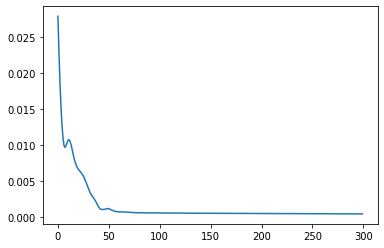

In [20]:
# plot the loss trend
plt.plot(history)

In [21]:
rnn.eval()
# test_inputs = torch.tensor(X_test).float().cuda()
test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()

In [29]:
mse = 0

for i in range(y_test.shape[0]):
  mse += pow((test_predict_cpu[i] - y_test[i]), 2)

mse = mse/y_test.shape[0]

print(mse)


[[0.00071727]]


In [22]:
test_predict_cpu.shape

(251, 1, 1)

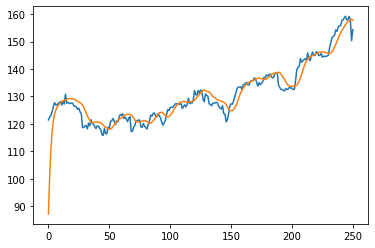

In [23]:
plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)))
plt.plot(scaler.inverse_transform(test_predict_cpu.reshape(-1,1)))

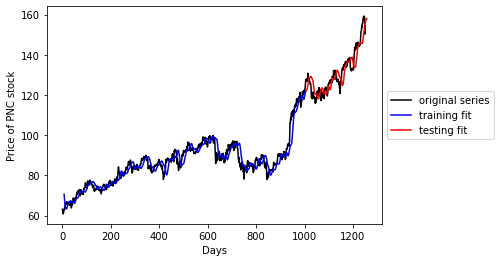

In [24]:
# plot original data
plt.plot(scaler.inverse_transform(y.reshape(-1,1)), color='k')

# train_inputs = torch.tensor(X_train).float().cuda()
train_pred, hidden_state = rnn(inputs_cuda, None)
train_pred_cpu = train_pred.cpu().detach().numpy()

# use hidden state from previous training data
test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()

# plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
split_pt = int(X.shape[0] * 0.80) + 7 # window_size
plt.plot(np.arange(7, split_pt, 1), scaler.inverse_transform(train_pred_cpu.reshape(-1,1)), color='b')
plt.plot(np.arange(split_pt, split_pt + len(test_predict_cpu), 1), scaler.inverse_transform(test_predict_cpu.reshape(-1,1)), color='r')

# pretty up graph
plt.xlabel('Days')
plt.ylabel('Price of PNC stock')
plt.legend(['original series','training fit','testing fit'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()